In [1]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

# Data Import and Cleaning

In [2]:
%store -r df_cleaned
df = df_cleaned 

In [3]:
TS1 = df[(df['Plz'] == "['25', '24']")]
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

# Modelling - Train, test split

In [4]:
nobs = 6
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

In [5]:
# df_train

## Prophet

In [6]:
import prophet

In [7]:
from prophet import Prophet

Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
- Datetime column named: ds
- target : y

In [8]:
#pjme_train_prophet = df_train.reset_index() 
pjme_train_prophet = df_train.rename(columns={'date':'ds',
                     'wPreis':'y'})
pjme_train_prophet = pjme_train_prophet[['ds', 'y']]

In [9]:
# pjme_train_prophet

In [10]:
# pjme_train_prophet.shape

In [11]:
model = Prophet()

Prophet does a static prediction by default. 
There does not seem to be an option to do a rolling window as the model simply outputs the predictions for the number of steps specified after taking in a set input.

So that leaves only walk-forward validation as the only option to compare.
In this, we can train the prophet model to predict just one step ahead and retrain at every step using the appended new observation. 

## Static Forecasting
For the first approach, we fit the model to the entire training dataset once.

In [12]:
model.fit(pjme_train_prophet)

06:28:39 - cmdstanpy - INFO - Chain [1] start processing
06:28:39 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
#pjme_train_prophet = df_train.reset_index() 
pjme_test_prophet = df_test.rename(columns={'date':'ds',
                     'wPreis':'y'})

pjme_test_prophet = pjme_test_prophet[['ds', 'y']]

The recommended approach with Prophet is to create a new dataframe using "make_future_dataframe" method with the number of periods specified (which we will specify as 6, for getting the predictions to compare with the length of the test data set).
To get the exact dates matching with that of the test data set, I had to specify the frequency as weekly, with a start of Monday.

In [14]:
future = model.make_future_dataframe(periods=6, freq='W-MON')


In [15]:
pjme_test_fcst_future = model.predict(future)
# pjme_test_fcst_future

Predicting on the newly created dataframe outputs a standard Prophet dataframe with various metrics for the prediction. The important one is yhat, which is the actual prediction value for the period steps.

In [16]:
# pjme_test_fcst_future.tail(10)

In [17]:
future_yhat = pjme_test_fcst_future['yhat'].iloc[-6:]
future_yhat

180    2.406815
181    0.497310
182   -0.743482
183   -1.971697
184   -3.705487
185   -5.795910
Name: yhat, dtype: float64

The predictions seem quite way off the mark, as seen in the plot as well.

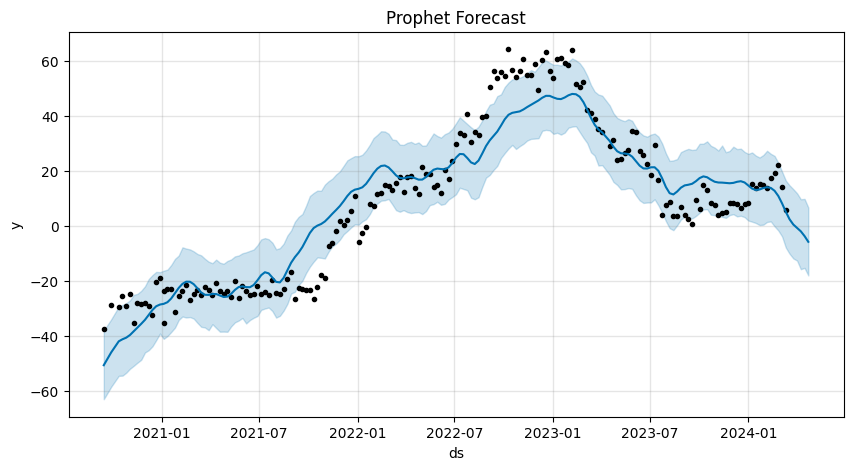

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst_future, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

In [19]:
def forecast_accuracy(forecast, actual):
      mae = mean_absolute_error(actual, forecast)
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'mae': mae,'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [20]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Prophet Forecast Accuracy of: wPreis')
stat_accuracy_prod = forecast_accuracy(pjme_test_fcst_future['yhat'].iloc[-6:].values, df_test['wPreis'])
for k, v in stat_accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Prophet Forecast Accuracy of: wPreis
mae    :  9.2617
me     :  -8.7437
rmse   :  11.4143
direction_accuracy :  0.4


In [21]:
Prophet_static = pd.DataFrame([stat_accuracy_prod])
Prophet_static



,mae,me,rmse,direction_accuracy
0,9.261666,-8.743701,11.414295,0.4


In [22]:
%store Prophet_static


Stored 'Prophet_static' (DataFrame)


In [23]:
future_yhat.index = df_test.index


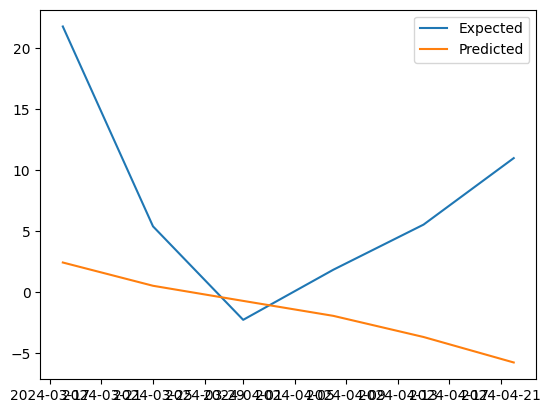

In [24]:
# plot expected vs preducted
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(future_yhat, label='Predicted')
plt.legend()
plt.show()

## Walk-forward validation

For walk-forward validation, just as before we train the model at every step of a loop where we append the training dataset with the newest step from the test data set and predict corresponding one-step at each stage to get a prediction list.

In [25]:
predictions = {}

In [26]:
for t in range(0,len(pjme_test_prophet)):
    print(t)

0
1
2
3
4
5


In [27]:
input = pjme_train_prophet #starting input as the original training dataset
for t in range(0,len(pjme_test_prophet)):
    model = Prophet() #Prophet requires an initialisation every time before fit
    model.fit(input) 
    future = model.make_future_dataframe(periods=1, freq='W-MON') # we only make the future dataframe for 1 step at a time now
    pred_step = model.predict(future) # and get the prediction "row" for that one step
    # print(pred_step.iloc[-1:]['yhat']) 
    predictions = pred_step[-1:]['yhat'] # adding the yhat value of the last, newest row in the predicted dataframe 
    new_obs = pjme_test_prophet.iloc[t] # getting the next row from the test dataframe
    # print(new_obs['y']) 
    input = input.append(new_obs, ignore_index=True) # appending the new row from the test dataframe to the input at every step


06:28:40 - cmdstanpy - INFO - Chain [1] start processing
06:28:40 - cmdstanpy - INFO - Chain [1] done processing
06:28:40 - cmdstanpy - INFO - Chain [1] start processing
06:28:40 - cmdstanpy - INFO - Chain [1] done processing
06:28:40 - cmdstanpy - INFO - Chain [1] start processing
06:28:40 - cmdstanpy - INFO - Chain [1] done processing
06:28:40 - cmdstanpy - INFO - Chain [1] start processing
06:28:40 - cmdstanpy - INFO - Chain [1] done processing
06:28:40 - cmdstanpy - INFO - Chain [1] start processing
06:28:40 - cmdstanpy - INFO - Chain [1] done processing
06:28:40 - cmdstanpy - INFO - Chain [1] start processing
06:28:40 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
# pred_step.head(15)

In [29]:
predictions = pred_step[-6:]['yhat']

In [30]:
predictions.index = pjme_test_prophet.index
# predictions

In [31]:
# pjme_test_prophet

In [32]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Prophet Forecast Accuracy of: wPreis')
wf_accuracy_prod = forecast_accuracy(predictions, pjme_test_prophet['y'])
for k, v in wf_accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Prophet Forecast Accuracy of: wPreis
mae    :  6.7319
me     :  -5.1069
rmse   :  8.7097
direction_accuracy :  0.4


In [33]:
Prophet_wf = pd.DataFrame([wf_accuracy_prod])
Prophet_wf



,mae,me,rmse,direction_accuracy
0,6.73186,-5.106923,8.70973,0.4


In [34]:
%store Prophet_wf 

Stored 'Prophet_wf' (DataFrame)


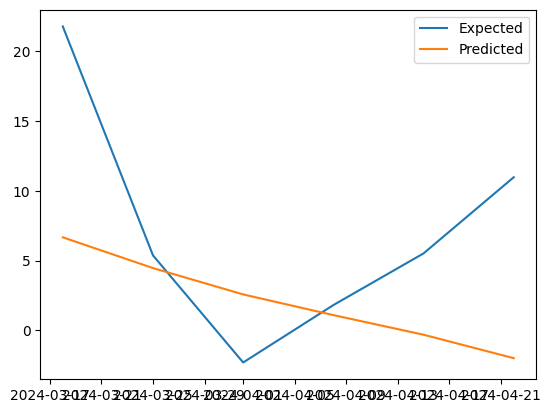

In [35]:
# plot expected vs preducted
plt.plot(pjme_test_prophet['y'], label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()